<a href="https://colab.research.google.com/github/jimmygohhanjie/create_instruction_finetune_dataset/blob/main/create_instr_FT_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create instructions fine-tuning dataset for LLAMA 2 lora tuning

we will use machine learning topics available in PDF for context.
utilize openai 3.5 turbo to generate json records for 2 instructions fine-tuning tasks

1.   summarization
2.   creating multiple choice questions (MCQ)


final dataset is stored in hugging face.

MCQ only in nested dictionary format. see MCQ expected output json format sample below
[apailang/dataset_mcq_table](https://huggingface.co/datasets/apailang/dataset_mcq_table)

and

summarization and mcq in dinctionary string format. see Summarization expected output json format sample below
[apailang/mini-dataset](https://huggingface.co/datasets/apailang/mini-dataset)
---



####Summarization expected output json format.


```


[{
        "instruction": "Summarize the concept and applications of AI",

        "input_content": "AI refers to the development of computer systems that can perform tasks that would normally require human intelligence. Some examples of AI applications .....",

        "expected_output": "AI, or artificial intelligence, involves the creation of computer systems capable of performing tasks that typically require human intelligence. Examples of AI applications include speech recognition systems used in self-driving cars, security systems, and medical imaging. AI algorithms are also used for personalized recommendations on e-commerce sites and streaming services, predictive maintenance in various industries, medical diagnosis systems, autonomous vehicles, fraud detection in financial institutions, image recognition in photo organization and security systems, natural language processing in chatbots and language translation systems, and predictive analytics in healthcare and marketing."
    }]
```


####MCQ expected output json format.



```
[
    {
        "instruction": "Create an MCQ on the structure of artificial neural networks",
        "input_content": "Artificial neural networks are built on the principles of the structure and operation of human neurons.......",

        "expected_output": {
            "question": "What is the structure of an artificial neural network?",
            "options": {
                "A": "It consists of input layers and hidden layers only",
                "B": "It consists of input layers, hidden layers, and output layers",
                "C": "It consists of input layers, hidden layers, output layers, and artificial neurons",
                "D": "It consists of input layers, hidden layers, output layers, artificial neurons, and weighted connections"
            },
            "correct_answer": "C",
            "explanation": "An artificial neural network consists of input layers, hidden layers, output layers, and artificial neurons. The input layer receives data from the outside world, the hidden layers process and compute the weighted total, and the output layer provides the final response. Artificial neurons are the units within the network, and the connections between neurons are weighted to optimize the impact of inputs from the preceding layer."
        }
    }
]
```




---



In [7]:
!pip install openai==0.28
!pip install PyPDF2
!pip install --upgrade tiktoken
!pip install -q datasets transformers sentence_transformers faiss-gpu huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00


###import libraries

In [8]:
# Import the required libraries
import openai
import PyPDF2

import json
import pandas as pd
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
import faiss
from tqdm.autonotebook import tqdm
import numpy as np

In [9]:
from huggingface_hub import notebook_login
notebook_login()

### helper functions


1.   convert pdfs to json
2.   append generate output json records



In [ ]:
def pdf_to_json(pdf_path, replace_newlines=True, indentation=4):
    """Converts a PDF document to JSON format, ensuring proper text formatting and
    optional newline replacement with spaces.

    Args:
        pdf_path (str): The path to the PDF file.
        replace_newlines (bool, optional): Whether to replace newlines with spaces.
                                          Defaults to True.
        indentation (int, optional): The level of indentation for JSON output.
                                      Defaults to 4.

    Returns:
        str: The JSON-formatted string representation of the PDF content.
    """

    with open(pdf_path, 'rb') as pdf_file:
        pdf_reader = PyPDF2.PdfReader(pdf_file)

        text_content = ""
        for page_num in range(len(pdf_reader.pages)):
            page = pdf_reader.pages[page_num]
            text_content += page.extract_text().strip() + "\n"

        # Preprocess text to remove unnecessary characters and spacing
        processed_text = text_content.replace('\r', '')  # Remove carriage returns
        if replace_newlines:
            processed_text = processed_text.replace('\n', ' ')  # Replace newlines with spaces
        else:
            # Preserve newlines if explicitly requested
            processed_text = processed_text.strip()

        # Create a JSON object with a single key "text" containing the processed text
        json_data = {"text": processed_text}

        # Return the JSON-formatted string with indentation for readability
        return json.dumps(json_data, indent=indentation)

# test usage:
pdf_path = "geeksforgeeks4.pdf"
json_string = pdf_to_json(pdf_path)
print(json_string)

{
    "text": "AI vs. Machine Learning vs. Deep Learning Examples: Arti\ufb01cial Intelligence (AI) refers to the development of computer systems that can perform tasks that would normally require human intelligence. Some examples of AI include: There are numerous examples of AI applications across various industries. Here are some common examples: \u25cf Speech recognition: speech recognition systems use deep learning algorithms to recognize and classify images and speech. These systems are used in a variety of applications, such as self-driving cars, security systems, and medical imaging. \u25cf Personalized recommendations: E-commerce sites and streaming services like Amazon and Net\ufb02ix use AI algorithms to analyze users\u2019 browsing and viewing history to recommend products and content that they are likely to be interested in. \u25cf Predictive maintenance: AI-powered predictive maintenance systems analyze data from sensors and other sources to predict when equipment is likel

In [ ]:
# openai.api_key = "your secret API Key" mr mar key
openai.api_key = "sk-xxxxx"

In [ ]:
model_engine ="gpt-3.5-turbo"
data=json_string


In [ ]:
#append json records
def append_to_json(file_path, new_records):
    """Appends new records to an existing JSON file.

    Args:
        file_path (str): The path to the existing JSON file.
        new_records (list): A list of new records to append, each record as a dictionary.
    """

    try:
        with open(file_path, "r") as f:
            existing_data = json.load(f)
    except FileNotFoundError:
        existing_data = []

    # Combine existing data with new records
    all_data = existing_data + new_records

    with open(file_path, "w") as f:
        json.dump(all_data, f, indent=4)  # Indent for readability

    print(f"New records appended to {file_path}")

###start of Summarization instrucions dataset generation

In [ ]:
def get_completion(prompt):
  messages=[{'role':'system', 'content':r"""
  As a machine learning education specialist, your expertise is pivotal in deepening the comprehension of complex machine learning concepts for both educators and students.

  Your role entails:

  Crafting Insightful Questions: Develop thought-provoking questions that explore the intricacies of machine learning topics.
  Providing Detailed Explanations: Deliver comprehensive answers to these questions, elucidating the underlying technical principles.
  Assisting in Exam Preparation: Support educators in formulating sophisticated exam and quiz questions, including MCQs, accompanied by thorough explanations.
  Summarizing Course Material: Distill key information from course materials, articulating complex ideas within the context of advanced machine learning practices.
  Generating MCQs: Create MCQs for each machine learning topic, comprising a question, four choices (A-D), and the correct answer, along with a rationale explaining the answer.

  Objective:
  Your primary goal is to compile an Instruction Dataset in a structured JSON format. This dataset should integrate specific instructions, relevant content on various machine learning topics, expected outputs with expert-level explanations, and summaries for student comprehension.

  Dataset Structure:
  Instruction: Specifies the task, such as summarizing, explaining, or creating MCQs.
  Input Content: Provides brief summary of context or inputs for the task.
  Expected Output: The detailed outcome produced by the model, potentially an explanation, summary.

  2 sample output JSON format:
  [
    {
        "instruction": "Summarize the concept and applications of AI",
        "input_content": "AI refers to the development of computer systems that can perform tasks that would normally require human intelligence. Some examples of AI applications include:",
        "expected_output": "AI, or artificial intelligence, involves the creation of computer systems capable of performing tasks that typically require human intelligence. Examples of AI applications include speech recognition systems used in self-driving cars, security systems, and medical imaging. AI algorithms are also used for personalized recommendations on e-commerce sites and streaming services, predictive maintenance in various industries, medical diagnosis systems, autonomous vehicles, fraud detection in financial institutions, image recognition in photo organization and security systems, natural language processing in chatbots and language translation systems, and predictive analytics in healthcare and marketing."
    },
    {
        "instruction": "Summarize the concept and applications of Machine Learning",
        "input_content": "Machine Learning is a subset of AI that focuses on enabling computer systems to learn from data and improve their performance without being explicitly programmed. Some examples of Machine Learning applications include:",
        "expected_output": "Machine Learning is a branch of AI that enables computer systems to learn from data and improve their performance without explicit programming. Examples of Machine Learning applications include speech recognition systems, personalized recommendations on e-commerce sites and streaming services, predictive maintenance systems, medical diagnosis systems, autonomous vehicles, fraud detection systems, image recognition applications, natural language processing systems, and predictive analytics in various industries."
    }
  ]

  """}]

  messages = messages+ prompt
  reponse = openai.ChatCompletion.create(
    model=model_engine,
    messages=messages,
    temperature=0.5)
  response = reponse['choices'][0]['message']['content']

  return response

In [ ]:
#mass query for summary

# List of file paths. #
file_paths = ["geeksforgeeks0.pdf","geeksforgeeks1.pdf", "geeksforgeeks2.pdf","geeksforgeeks3.pdf", "geeksforgeeks4.pdf","geeksforgeeks5.pdf","geeksforgeeks6.pdf","geeksforgeeks7.pdf","geeksforgeeks8.pdf","geeksforgeeks9.pdf","geeksforgeeks10.pdf","geeksforgeeks11.pdf","geeksforgeeks12.pdf"]  # Replace with your actual file paths

# Initialize an empty list to store all query data
all_query_data = []

# Iterate through each file path
for file_path in file_paths:
    # Initialize an empty list to store query data for the current file
    query_data = []
    print(file_path)
    #convert pdf to json
    json_data = pdf_to_json(file_path)

    # Loop 10 times to generate 10 summarization records for each file
    for i in range(1):
        i+1
        prompt_template= f"""
        For given {json_data}, create 4 subject summary to aid examination prepration.
        """
        query = get_completion([{'role':'user', 'content':prompt_template}] )
        print(query)

        # Append the query to the query_data list for the current file
        new_records = json.loads(query)
        append_to_json("my_data.json", new_records)



geeksforgeeks0.pdf
[
  {
    "instruction": "Summarize the concept of artificial neural networks",
    "input_content": "Artificial neural networks are built on the principles of the structure and operation of human neurons. They consist of input layers, hidden layers, and output layers. Neurons in the hidden layer receive information from the previous layer, compute a weighted total, and pass it on to the next layer. The weights of the connections between neurons are adjusted during training to improve the model's performance.",
    "expected_output": "Artificial neural networks are modeled after human neurons and consist of input, hidden, and output layers. Neurons in the hidden layer receive input from the previous layer, calculate a weighted total, and pass it to the next layer. The weights of the connections between neurons are adjusted during training to enhance the model's performance."
  },
  {
    "instruction": "Explain the structure of an artificial neural network",
    "inp

In [ ]:
def get_completion_MCQ(prompt):
  messages=[{'role':'system', 'content':r"""
  As a machine learning education specialist, your expertise is pivotal in deepening the comprehension of complex machine learning concepts for both educators and students.

  Your role entails:

  Crafting Insightful Questions: Develop thought-provoking questions that explore the intricacies of machine learning topics.
  Providing Detailed Explanations: Deliver comprehensive answers to these questions, elucidating the underlying technical principles.
  Assisting in Exam Preparation: Support educators in formulating sophisticated exam and quiz questions, including MCQs, accompanied by thorough explanations.
  Summarizing Course Material: Distill key information from course materials, articulating complex ideas within the context of advanced machine learning practices.
  Generating MCQs: Create MCQs for each machine learning topic, comprising a question, four choices (A-D), and the correct answer, along with a rationale explaining the answer.

  Objective:
  Your primary goal is to compile an Instruction Dataset in a structured JSON format. This dataset should integrate specific instructions, relevant content on various machine learning topics, expected outputs with expert-level explanations, and MCQs designed to evaluate comprehension.
  Dataset Structure:

  Instruction: Specifies the task, such as summarizing, explaining, or creating MCQs.
  Input Content: Provides brief summary of context or inputs for the task. Can be left blank if not needed.
  Expected Output: The detailed answer or outcome produced by the model, potentially an explanation, summary, or an MCQ with its answer and justification.

    Each JSON record entries format:
    {
      "instruction": "Create an MCQ on the importance of cross-validation in machine learning",
      "input_content": "",
      "expected_output": {
        "question": "What is the primary purpose of cross-validation in machine learning?",
        "options": {
          "A": "To increase the speed of training models",
          "B": "To prevent overfitting by validating the model with different data subsets",
          "C": "To enhance the model's performance on the training data",
          "D": "To reduce the computational cost of training"
        },
        "correct_answer": "B",
        "explanation": "Cross-validation assesses a model's generalization to independent datasets by training and testing on various data segments, effectively preventing overfitting."
      }
    }
  """}]

  messages = messages+ prompt
  reponse = openai.ChatCompletion.create(
    model=model_engine,
    messages=messages,
    temperature=0.3)
  response = reponse['choices'][0]['message']['content']

  return response

###start of MCQ instrucions dataset generation

In [ ]:
#mass query for MCQ

# List of file paths
file_paths = ["geeksforgeeks0.pdf","geeksforgeeks1.pdf", "geeksforgeeks2.pdf", "geeksforgeeks3.pdf","geeksforgeeks4.pdf","geeksforgeeks5.pdf","geeksforgeeks6.pdf","geeksforgeeks7.pdf","geeksforgeeks8.pdf","geeksforgeeks9.pdf","geeksforgeeks10.pdf","geeksforgeeks11.pdf","geeksforgeeks12.pdf"]  # Replace with your actual file paths
#file_paths = ["geeksforgeeks4.pdf"]#, "geeksforgeeks2.pdf"]
# Initialize an empty list to store all query data
all_query_data = []

# Iterate through each file path
for file_path in file_paths:
    # Initialize an empty list to store query data for the current file
    query_data = []
    print(file_path)
    #convert pdf to json
    json_data = pdf_to_json(file_path)

    # Loop 10 times to generate 10 summarization records for each file
    for i in range(1):
        i+1

        # Get the completion from the API
        prompt_template= f"""
        For given {json_data}, create 5 MCQ questions.
        """
        query = get_completion_MCQ([{'role':'user', 'content':prompt_template}] )
        print(query)

        # Append the query to the query_data list for the current file
        new_records = json.loads(query)
        append_to_json("my_data_MCQ.json", new_records)

### creation of apailang/dataset_mcq_table



In [10]:
import json
import pandas as pd

## load from mcq json and change expected_output into a table from nested dict

def load_json_and_convert(file_path):
    """Loads a JSON file and converts "expected_output" to a string."""

    with open(file_path, "r") as json_file:
        data = json.load(json_file)

    for entry in data:
        entry["question"] = entry["expected_output"]["question"]
        entry["A"] = entry["expected_output"]["options"]["A"]
        entry["B"] = entry["expected_output"]["options"]["B"]
        entry["C"] = entry["expected_output"]["options"]["C"]
        entry["D"] = entry["expected_output"]["options"]["D"]
        entry["correct_answer"] = entry["expected_output"]["correct_answer"]
        entry["explanation"] = entry["expected_output"]["explanation"]

    return data


file_path = "my_data_MCQ.json"  # Replace with your actual file path
processed_data = load_json_and_convert(file_path)

processed_data[0]


df = pd.DataFrame(processed_data)


# Create a DatasetDict with the "train" split
dataset_mcq_table = DatasetDict({
   "train": Dataset.from_pandas(df[:318], split="train"),
   "test": Dataset.from_pandas(df[318:368], split="test"),
   "val": Dataset.from_pandas(df[368:418], split="val"),
})

print(dataset_mcq_table)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input_content', 'expected_output', 'question', 'A', 'B', 'C', 'D', 'correct_answer', 'explanation'],
        num_rows: 318
    })
    test: Dataset({
        features: ['instruction', 'input_content', 'expected_output', 'question', 'A', 'B', 'C', 'D', 'correct_answer', 'explanation'],
        num_rows: 50
    })
    val: Dataset({
        features: ['instruction', 'input_content', 'expected_output', 'question', 'A', 'B', 'C', 'D', 'correct_answer', 'explanation'],
        num_rows: 50
    })
})


In [11]:
# Push to Hugging Face Hub
dataset_mcq_table.push_to_hub("apailang/dataset_mcq_table")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/apailang/dataset_mcq_table/commit/8a6f7707c2288209909188179e26865101646243', commit_message='Upload dataset', commit_description='', oid='8a6f7707c2288209909188179e26865101646243', pr_url=None, pr_revision=None, pr_num=None)

### creation of apailang/mini-dataset-978


In [12]:
#to check no. of records in Json
def count_records_in_json(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)

    # Determine the type of data structure
    if isinstance(data, list):
        return len(data)  # Count elements in a list
    elif isinstance(data, dict):
        return len(data.keys())  # Count keys in a dictionary
    else:
        raise ValueError(f"Unsupported JSON data structure: {type(data)}")

# Example usage:
file_path = "combined_data.json"
record_count = count_records_in_json(file_path)
print(f"Number of records in {file_path}: {record_count}")

Number of records in combined_data.json: 978


In [13]:
## load from mcq json and change expected_output into a string from dict

def format_expected_output(expected_output):
    """Formats the expected_output dictionary into a single string."""

    if not isinstance(expected_output, dict) or not all(key in expected_output for key in ["question", "options", "correct_answer", "explanation"]):
        raise ValueError("Invalid expected_output format: missing required keys.")

    string = f"[question]: {expected_output['question']} "

    for option, value in expected_output['options'].items():
        string += f"[option {option}]: {value}. "

    string += f"[correct_answer]: {expected_output['correct_answer']}, [explanation]:{expected_output['explanation']}"
    return string

def load_json_and_convert(file_path):
    """Loads a JSON file and converts "expected_output" to a string."""

    with open(file_path, "r") as json_file:
        data = json.load(json_file)

    for entry in data:
        entry["expected_output"] = format_expected_output(entry["expected_output"])

    return data


file_path = "my_data_MCQ.json"  # Replace with your actual file path
processed_data = load_json_and_convert(file_path)

df = pd.DataFrame(processed_data)


# Create a DatasetDict with the "train" split
dataset_mcq = DatasetDict({
    "train": Dataset.from_pandas(df, split="train")
})

print(dataset_mcq)

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input_content', 'expected_output'],
        num_rows: 418
    })
})


In [14]:
with open("data_mcq_string.json", "w") as f:
    json.dump(dataset_mcq["train"].to_list(), f, indent=4)

In [26]:
from datasets import load_dataset
from collections import OrderedDict

dataset_mcq = load_dataset('json', data_files='data_mcq_string.json')

dataset_sum = load_dataset('json', data_files='my_data.json')

combined_dataset = concatenate_datasets([dataset_sum['train'], dataset_mcq['train']])

In [27]:
print(combined_dataset)
print(combined_dataset[560])

Dataset({
    features: ['expected_output', 'instruction', 'input_content'],
    num_rows: 978
})
{'expected_output': '[question]: What is the structure of an artificial neural network? [option A]: It consists of input layers and hidden layers only. [option B]: It consists of input layers, hidden layers, and output layers. [option C]: It consists of input layers, hidden layers, output layers, and artificial neurons. [option D]: It consists of input layers, hidden layers, output layers, artificial neurons, and weighted connections. [correct_answer]: C, [explanation]:An artificial neural network consists of input layers, hidden layers, output layers, and artificial neurons. The input layer receives data from the outside world, the hidden layers process and compute the weighted total, and the output layer provides the final response. Artificial neurons are the units within the network, and the connections between neurons are weighted to optimize the impact of inputs from the preceding lay

#EDA for created dataset

1) check for token >2048

2) top-k sampling

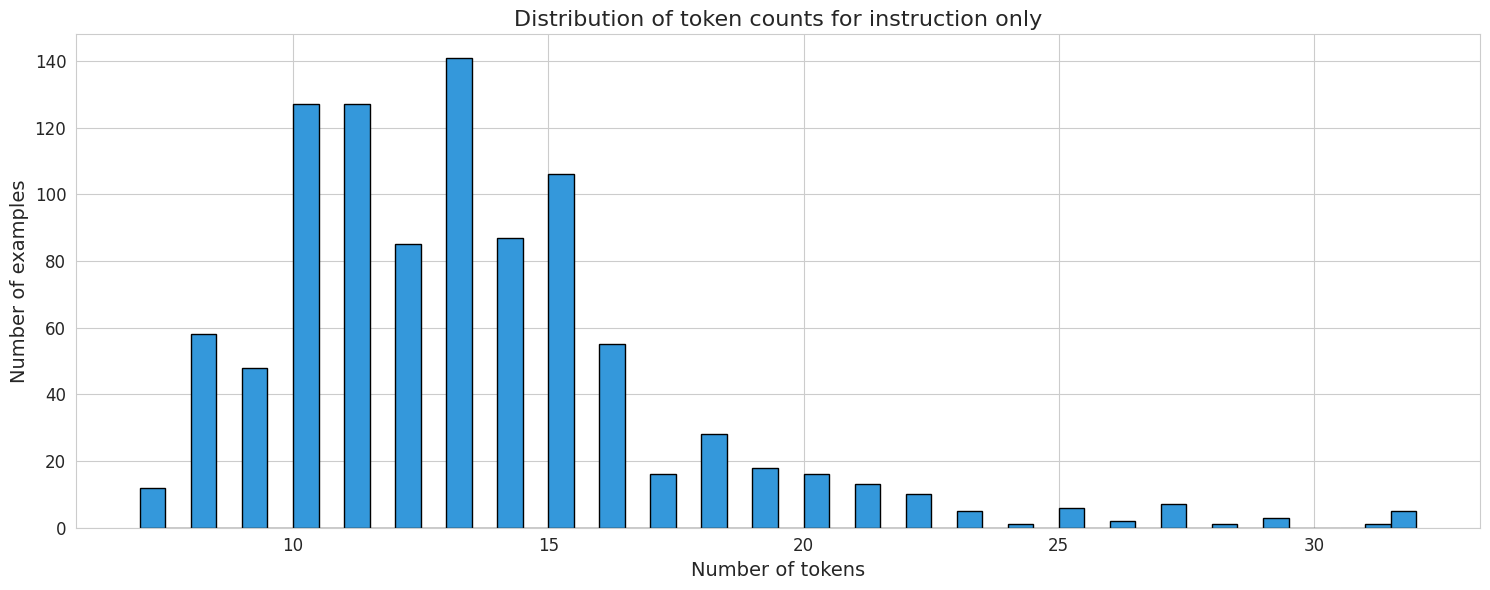

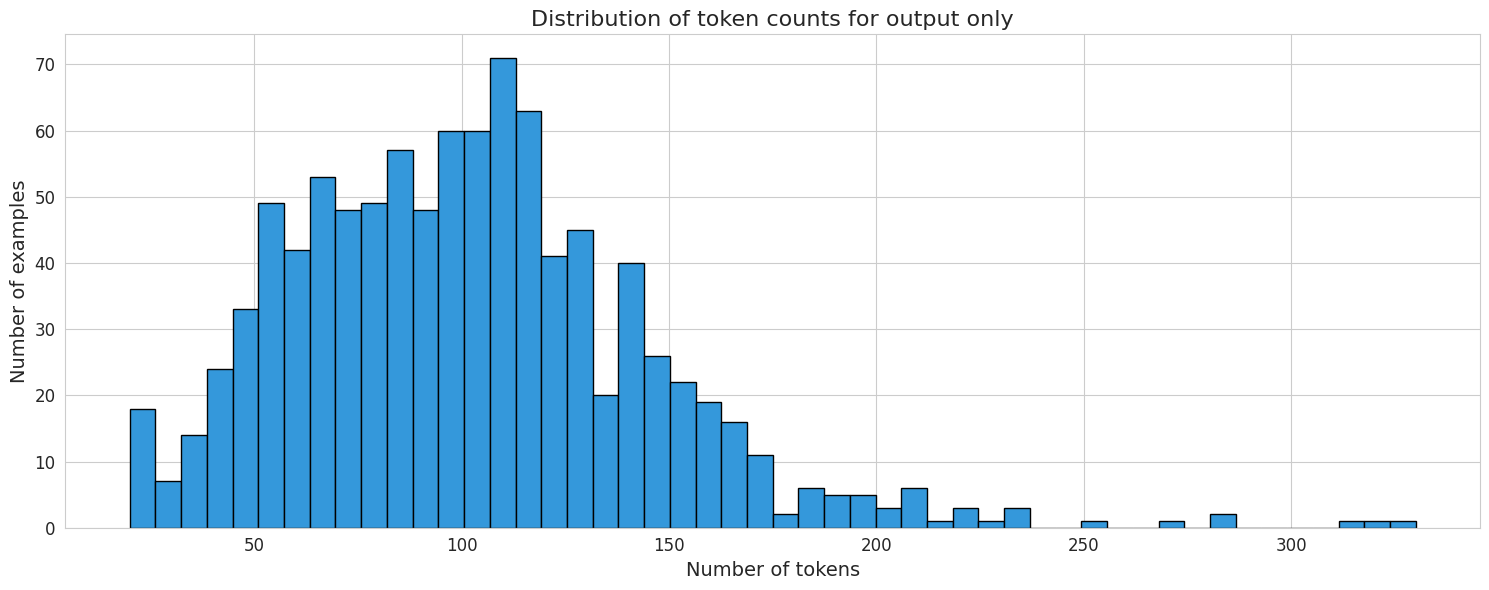

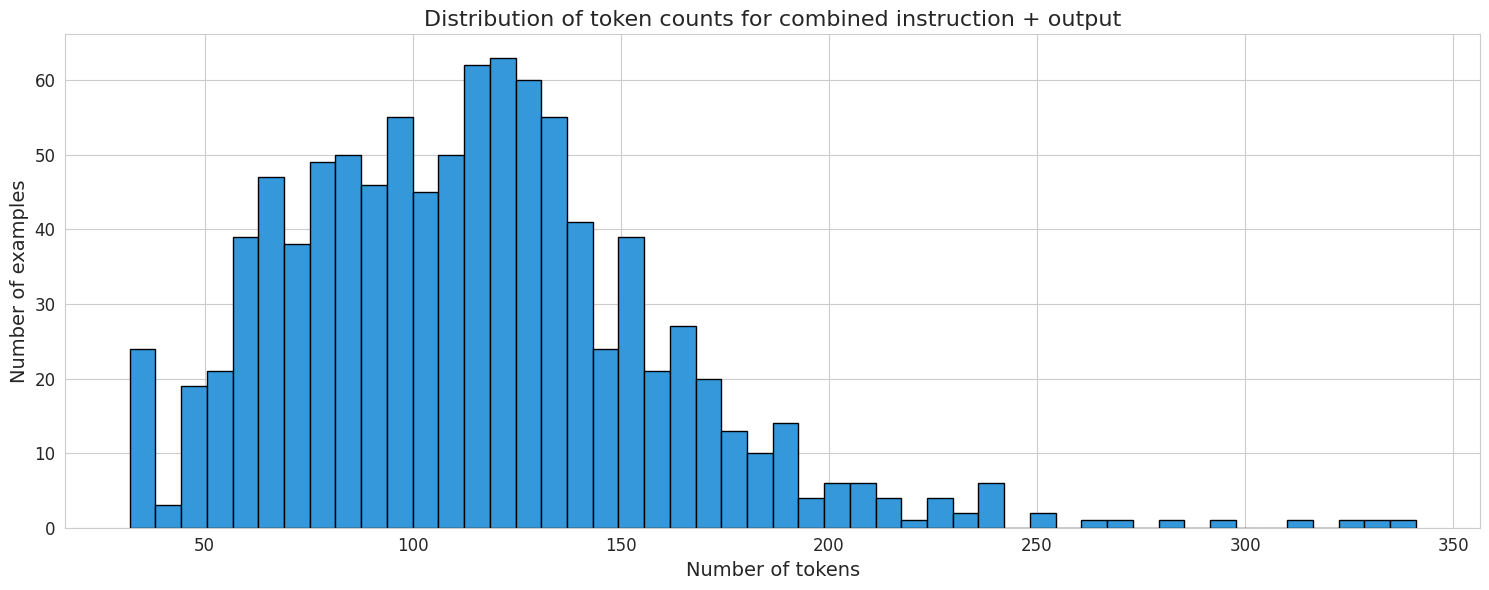

In [28]:
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

#dataset= dataset_mcq['train']
dataset=combined_dataset
# 2. Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset]
output_token_counts = [len(tokenizer.tokenize(example["expected_output"])) for example in dataset]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

##Filter out rows with more than 2048 tokens

We will remove samples with more than 2048 tokens (max context size of Llama 2 by default = 4096).

Number of valid rows: 978
Removing 0 rows...


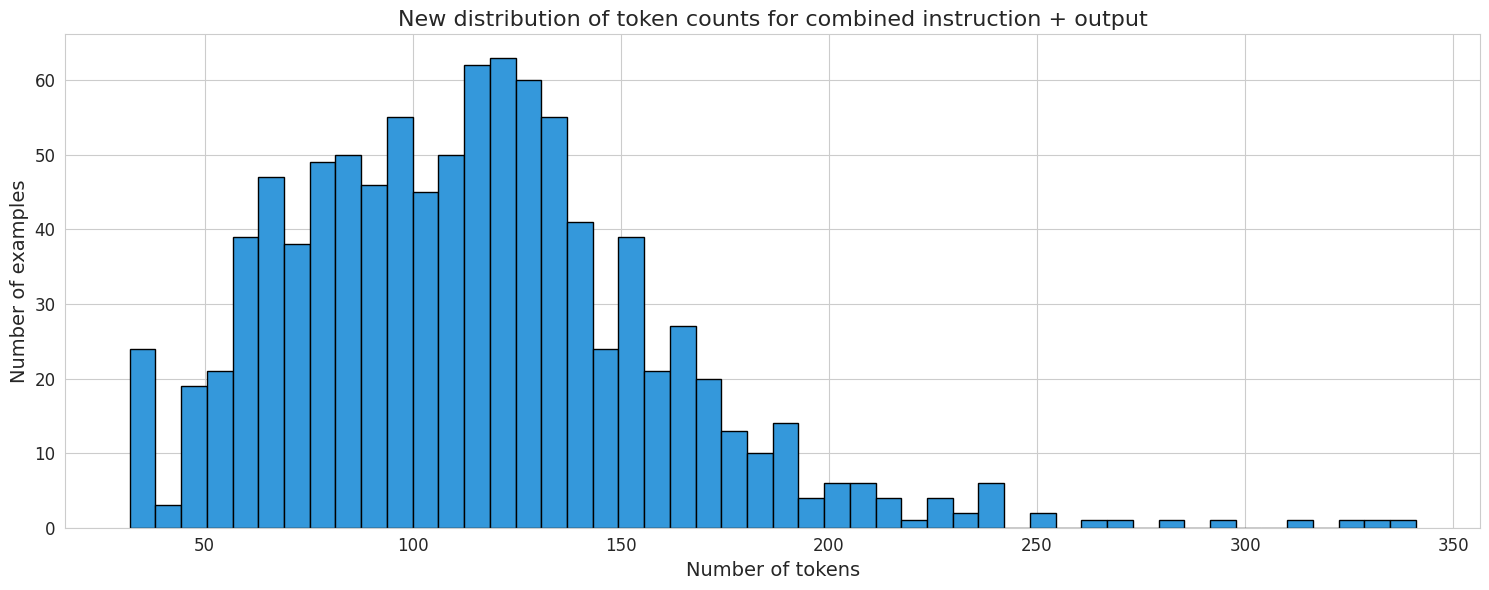

In [29]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset = dataset.select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

##Top-k sampling

Only keep the top k samples with the most tokens.

In [30]:
# Define a function to get the top k rows based on the number of tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort the indices of the token counts in descending order and select the top k
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract the instruction and output for the top k rows
    top_k_data = {
        "instruction": [dataset[i]["instruction"] for i in top_k_indices], #dataset['train']
        "output": [dataset[i]["expected_output"] for i in top_k_indices] #dataset['train']
    }

    # Return a new dataset created from the top k rows
    return Dataset.from_dict(top_k_data)

# Calculate the number of tokens in each instruction and output in the deduplicated dataset
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset]
output_token_counts = [len(tokenizer.tokenize(example["expected_output"])) for example in dataset]

# Combine the token counts for instructions and outputs
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Specify the number of rows to retrieve
k = 1000  # You can adjust this value as needed

# Retrieve the top k rows with the most tokens from the deduplicated dataset
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k) #deduped_dataset

# Create a DatasetDict object containing the top k dataset with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

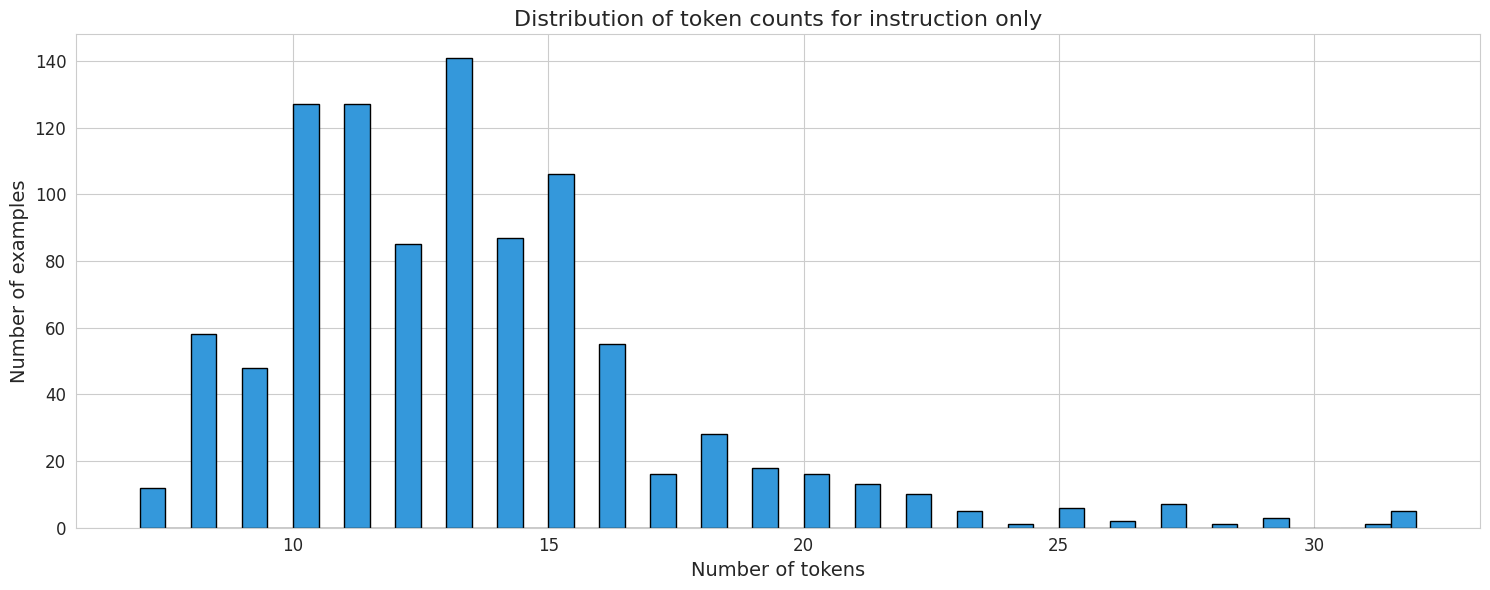

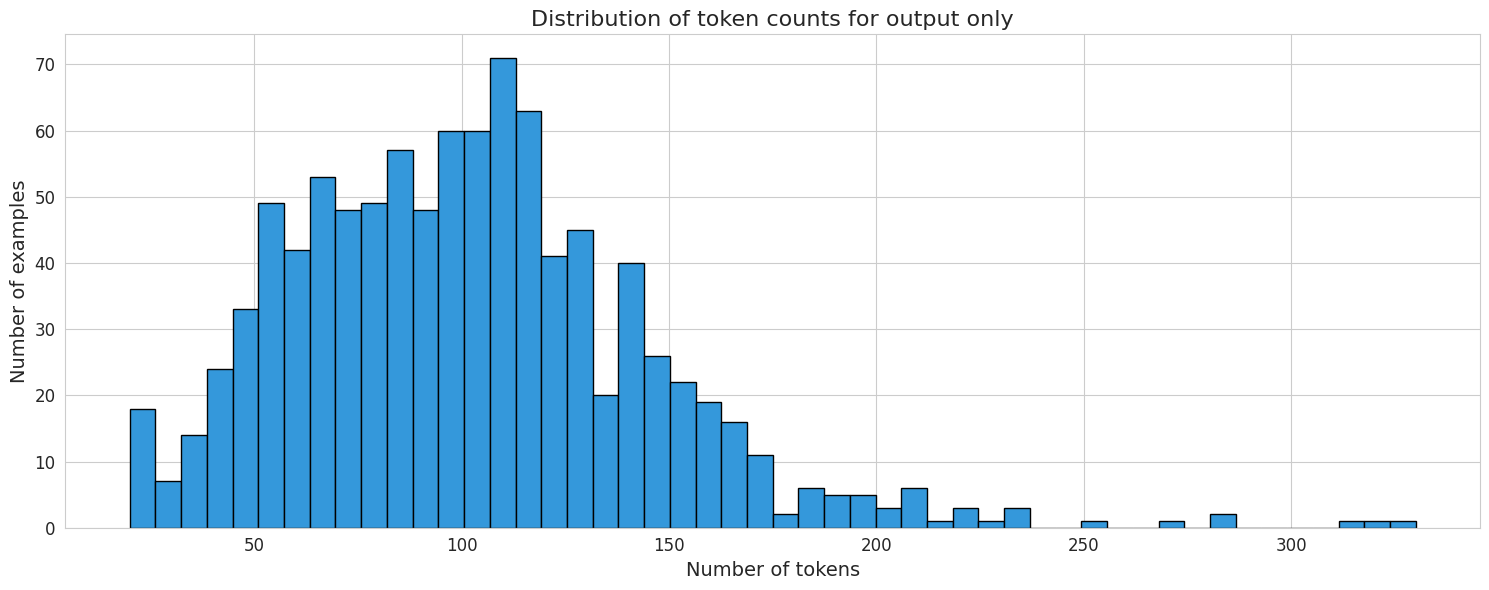

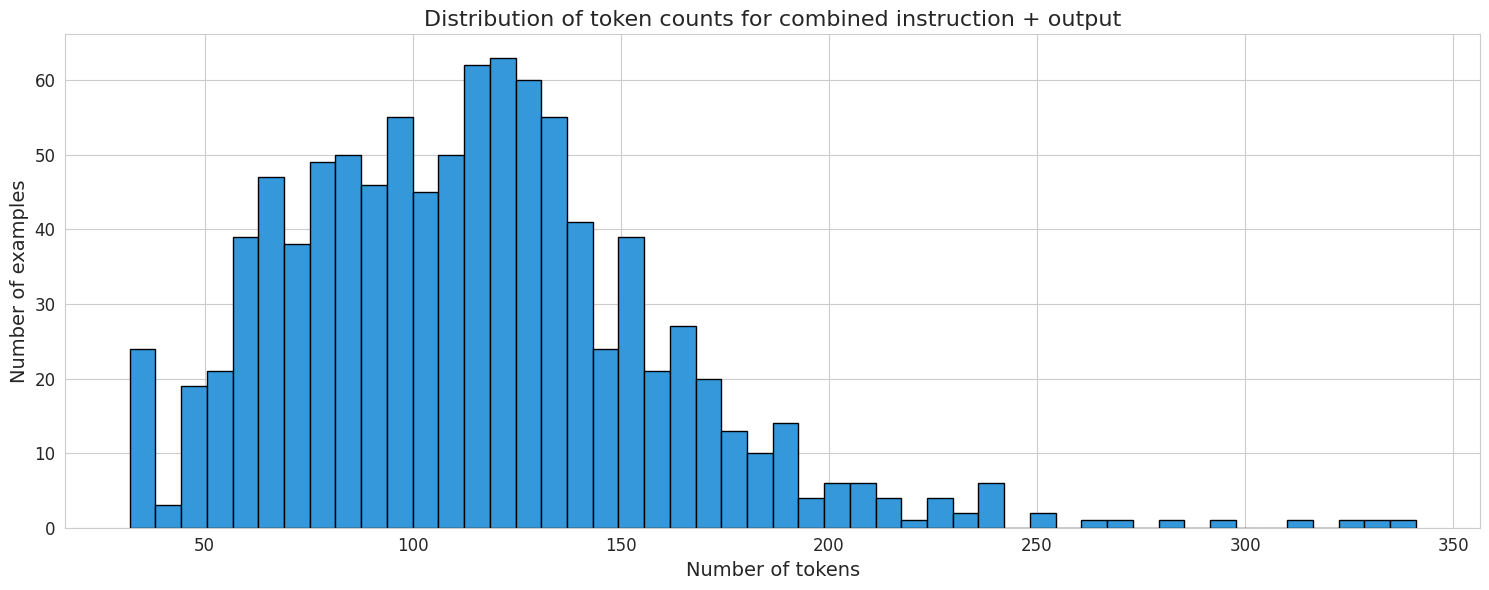

In [31]:
# Calculate the number of tokens in each instruction in the training set
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]

# Calculate the number of tokens in each output in the training set
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]

# Combine the token counts of instruction and output for each example
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plotting the token count distributions
# Plot for distribution of token counts in instructions
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")

# Plot for distribution of token counts in outputs
plot_distribution(output_token_counts, "Distribution of token counts for output only")

# Plot for distribution of combined token counts in both instructions and outputs
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# Convert the 'train' split of the dataset to a Pandas DataFrame for easier analysis and manipulation
dataset.to_pandas()

In [33]:
# Push to Hugging Face Hub
dataset.push_to_hub("apailang/mini-dataset-978")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/apailang/mini-dataset-978/commit/538c7d3ff01cd18c628a11a1cbc16f5276c4bf18', commit_message='Upload dataset', commit_description='', oid='538c7d3ff01cd18c628a11a1cbc16f5276c4bf18', pr_url=None, pr_revision=None, pr_num=None)


END

---
appendix


To check prompt input tokens required for each pdf

In [ ]:
#to check token used

# List of file paths
file_paths = ["geeksforgeeks0.pdf","geeksforgeeks1.pdf", "geeksforgeeks2.pdf", "geeksforgeeks3.pdf","geeksforgeeks4.pdf","geeksforgeeks5.pdf","geeksforgeeks6.pdf","geeksforgeeks7.pdf","geeksforgeeks8.pdf","geeksforgeeks9.pdf","geeksforgeeks10.pdf","geeksforgeeks11.pdf","geeksforgeeks12.pdf"]  # Replace with your actual file paths

all_query_data = []

# Iterate through each file path
for file_path in file_paths:
    # Initialize an empty list to store query data for the current file
    query_data = []
    print(file_path)
    #convert pdf to json
    json_data = pdf_to_json(file_path)

    # Loop 10 times to generate 10 summarization records for each file
    for i in range(1):
        i+1
        print(i)
        # Generate the prompt for the current iteration


        # Get the completion from the API

        #query = get_completion([{'role':'user', 'content':f"please summarize the topic and provide in 3 summarization records in format of 3 pointer, instruction,context,response. sample output instruction is to clearly indicate topic and learning objective, context is sample data paragraph and response is summarized output."}],json_data )
        prompt_template= f"""
        For given {json_data} provide 2 concise summary of the topics presented in the content.

        Examples:
        1. Instruction: Explain the concept of hyperparameter tuning.
        Context: A machine learning model has parameters that can be learned from data, but there are also hyperparameters that need to be set before training. Hyperparameter tuning is the process of selecting the optimal values for these hyperparameters.
        Response: Hyperparameter tuning is the process of selecting the best values for a machine learning model's hyperparameters, which control its learning process and can significantly impact its performance.

        2. Instruction: Describe the difference between hyperparameters and model parameters.
        Context: Hyperparameters are configuration variables set before training, while model parameters are learned from data. Hyperparameters control the learning process, while model parameters are the weights and biases of the model.
        Response: Hyperparameters are set before training and control the learning process, while model parameters are learned from data and represent the weights and biases of the model.
        """
        query = get_completion([{'role':'user', 'content':prompt_template}] )
        print(num_tokens_from_string(prompt_template, "cl100k_base"))





geeksforgeeks0.pdf
0
1616
geeksforgeeks1.pdf
0
2203
geeksforgeeks2.pdf
0
1715
geeksforgeeks3.pdf
0
1593
geeksforgeeks4.pdf
0
1238
geeksforgeeks5.pdf
0
2219
geeksforgeeks6.pdf
0
1864
geeksforgeeks7.pdf
0
1452
geeksforgeeks8.pdf
0
2397
geeksforgeeks9.pdf
0
1334
geeksforgeeks10.pdf
0
1384
geeksforgeeks11.pdf
0
1481
geeksforgeeks12.pdf
0
1009
